# Restaurant Analysis

#### Import Necessary Library

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from geopy.distance  import geodesic
from scipy.stats import pointbiserialr
from scipy.stats import ttest_ind
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
file = "/workspaces/Restaurant-Analysis/Data/Dataset .csv"

In [4]:
rest_df = pd.read_csv(file)

In [5]:
rest_df.head(3)

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270


### Exploring the Dataset

In [6]:
rest_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average Cost for two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has Table booking     9551 non-null   object 
 13  Has Online delivery   9551 non-null   object 
 14  Is delivering now     9551 non-null   object 
 15  Switch to order menu 

In [7]:
rest_df.shape

(9551, 21)

In [8]:
rest_df.isnull().sum()

Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64

In [9]:
rest_df.duplicated(['Restaurant ID']).sum()

np.int64(0)

### Data Cleansing

In [10]:
def str_miss(df,col):
    miss_value = df[df[col].isnull()]
    city = miss_value['City'].unique()
    for cit in city:
        city_df = df[df['City'] == cit]
        mode_value = city_df[col].mode()
        df.loc[df['City'] == cit, col] = df.loc[df['City'] == cit, col].fillna(mode_value).iloc[0]

    return df


rest_df = str_miss(rest_df,'Cuisines')

In [11]:
rest_df[rest_df['Cuisines'].isnull()]

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
346,17606621,HI Lite Bar & Lounge,216,Miller,"109 N Broadway Ave, Miller, SD 57362",Miller,"Miller, Miller",-98.9891,44.5158,NaN,...,Dollar($),No,No,No,No,1,3.4,Orange,Average,11


In [12]:
rest_df['Cuisines'] = rest_df['Cuisines'].fillna('Unknown')

In [13]:
rest_df = rest_df.drop(columns = 'Locality Verbose')

In [14]:
cat = [c for c in rest_df.select_dtypes(include = ['object']).columns if rest_df[c].nunique()<=6 & rest_df[c].nunique()>1]
rest_df[cat] = rest_df[cat].astype('category')
rest_df['Country Code'] = rest_df['Country Code'].astype('int32')

In [15]:
rest_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Restaurant ID         9551 non-null   int64   
 1   Restaurant Name       9551 non-null   object  
 2   Country Code          9551 non-null   int32   
 3   City                  9551 non-null   object  
 4   Address               9551 non-null   object  
 5   Locality              9551 non-null   object  
 6   Longitude             9551 non-null   float64 
 7   Latitude              9551 non-null   float64 
 8   Cuisines              9551 non-null   object  
 9   Average Cost for two  9551 non-null   int64   
 10  Currency              9551 non-null   object  
 11  Has Table booking     9551 non-null   category
 12  Has Online delivery   9551 non-null   category
 13  Is delivering now     9551 non-null   category
 14  Switch to order menu  9551 non-null   object  
 15  Pric

### EDA (Exploratory Data Analysis)

In [16]:
rest_df.describe()

,Restaurant ID,Country Code,Longitude,Latitude,Average Cost for two,Price range,Aggregate rating,Votes
count,9.551000e+03,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000
mean,9.051128e+06,18.365616,64.126574,25.854381,1199.210763,1.804837,2.666370,156.909748
std,8.791521e+06,56.750546,41.467058,11.007935,16121.183073,0.905609,1.516378,430.169145
min,5.300000e+01,1.000000,-157.948486,-41.330428,0.000000,1.000000,0.000000,0.000000
25%,3.019625e+05,1.000000,77.081343,28.478713,250.000000,1.000000,2.500000,5.000000
50%,6.004089e+06,1.000000,77.191964,28.570469,400.000000,2.000000,3.200000,31.000000
75%,1.835229e+07,1.000000,77.282006,28.642758,700.000000,2.000000,3.700000,131.000000
max,1.850065e+07,216.000000,174.832089,55.976980,800000.000000,4.000000,4.900000,10934.000000


In [17]:
dit = {1:"India",216:'US',215:'UK',30:"Brazil",189:"South Africa",214:"UAE",148:"New Zealand",208:"Turkey",14:"Australia",162:"Philippines",
       94:"Indonesia",166:"Qatar",184:"Singapore",191:"Sri Lanka",37:"Canada"}

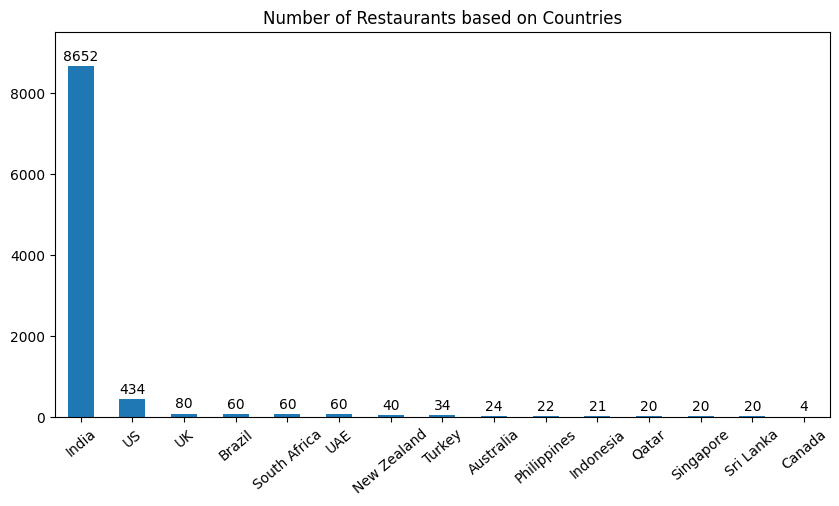

In [18]:
plt.figure(figsize=(10,5))
country = rest_df['Country Code'].map(dit).value_counts()
px = country.plot(kind='bar')
px.bar_label(px.containers[0], label_type= 'edge',padding = 2)
plt.xticks(rotation=40) 
plt.ylim(0,9500)
plt.xlabel("")
plt.title("Number of Restaurants based on Countries")
plt.show()

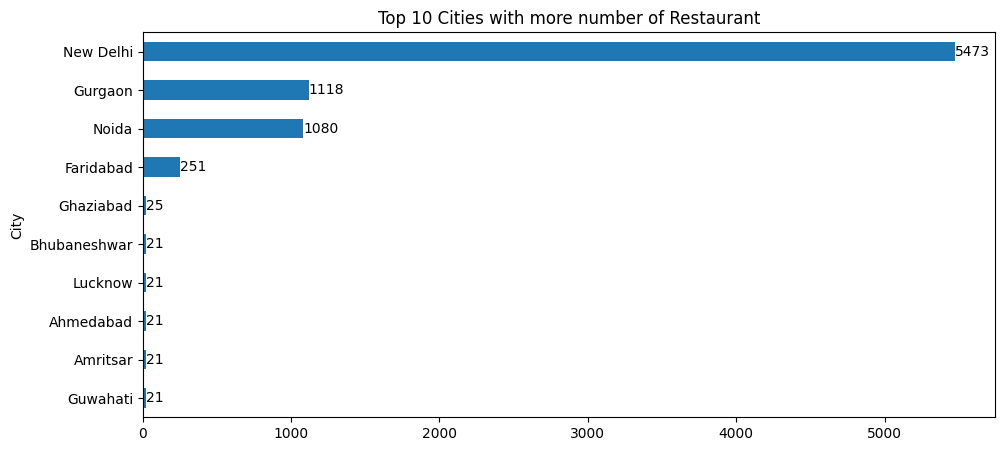

In [19]:
city = rest_df['City'].value_counts()
plt.figure(figsize=(11,5))
city = rest_df['City'].value_counts()[:10][::-1].plot(kind='barh')
plt.title("Top 10 Cities with more number of Restaurant")
city.bar_label(city.containers[0])
plt.show()

In [20]:
rest_df['Cuisines'] = rest_df['Cuisines'].str.split(',')
df_cuisines = rest_df.explode('Cuisines')
df_cuisines['Cuisines'] = df_cuisines['Cuisines'].str.strip() # To avoid unnecessary spaces
df_cuisines.shape # To check

(19727, 20)

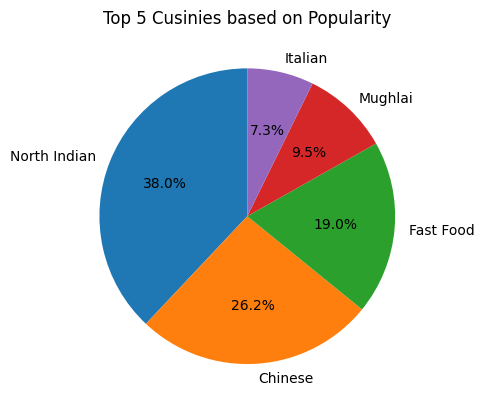

In [21]:
df_cuisines['Cuisines'].value_counts()[:5].plot(kind='pie',autopct = '%1.1f%%',startangle = 90)
plt.ylabel("")
plt.title("Top 5 Cusinies based on Popularity")
plt.show()

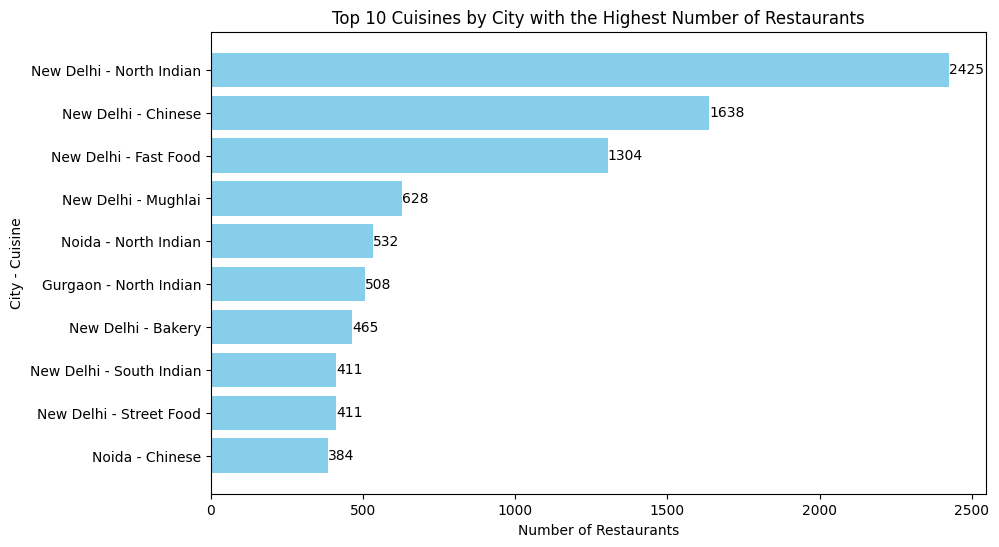

In [22]:
top_10 = df_cuisines.groupby(['City','Cuisines'])['Restaurant Name'].count().sort_values(ascending=False).reset_index()[:10]
plt.figure(figsize=(10, 6))
ax = plt.barh(top_10.apply(lambda x: f"{x['City']} - {x['Cuisines']}", axis=1),top_10['Restaurant Name'],color='skyblue')
plt.bar_label(ax,labels = top_10['Restaurant Name'], label_type='edge')
plt.gca().invert_yaxis()
plt.title("Top 10 Cuisines by City with the Highest Number of Restaurants")
plt.xlabel("Number of Restaurants")
plt.ylabel("City - Cuisine")
plt.show()

In [23]:
correlation_lat = rest_df['Latitude'].corr(rest_df['Aggregate rating'])
correlation_lon = rest_df['Longitude'].corr(rest_df['Aggregate rating'])

print("Correlation between Latitude and Rating:", correlation_lat)
print("Correlation between Longitude and Rating:", correlation_lon)

Correlation between Latitude and Rating: 0.0005155806902359908
Correlation between Longitude and Rating: -0.11681757734540431


In [24]:
capital_coordinates = {
    "India": (28.6139, 77.2090),  # New Delhi
    "US": (38.8954, -77.0365),  # Washington D.C.
    "UK": (51.5074, -0.1278),  # London
    "Brazil": (-15.7801, -47.9292),  # Brasília
    "South Africa": (-25.7460, 28.1881),  # Pretoria
    "UAE": (25.276987, 55.296249),  # Abu Dhabi
    "New Zealand": (-41.2867, 174.7752),  # Wellington
    "Turkey": (39.9334, 32.8597),  # Ankara
    "Australia": (-35.2809, 149.1300),  # Canberra
    "Philippines": (14.5995, 120.9842),  # Manila
    "Indonesia": (-6.1751, 106.8650),  # Jakarta
    "Qatar": (25.276987, 51.520008),  # Doha
    "Singapore": (1.3521, 103.8198),  # Singapore City
    "Sri Lanka": (6.9271, 79.8612),  # Colombo
    "Canada": (45.4215, -75.6992)  # Ottawa
}

Country_df = rest_df.copy() # For precaustion
Country_df['Country_name'] = Country_df['Country Code'].map(dit)

In [25]:
def loc_distance(col,cap_cor):
    capital = col['Country_name']
    if capital in capital_coordinates:
        reference = cap_cor[capital]
        return geodesic((col['Latitude'],col['Longitude']),reference).km
    else:
        return None


Country_df['Distance_to_reference'] = Country_df.apply(loc_distance,cap_cor = capital_coordinates, axis = 1)

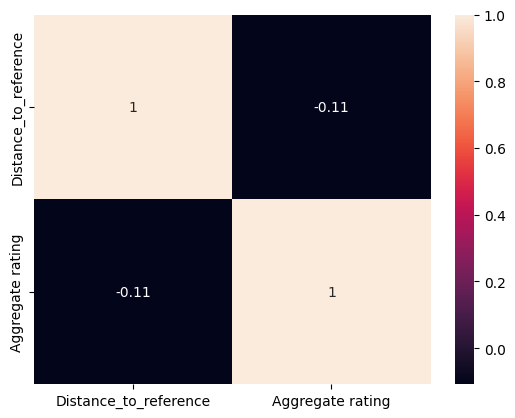

In [26]:
corr_mat = Country_df[['Distance_to_reference','Aggregate rating']].corr()
sns.heatmap(corr_mat,annot=True)
plt.show()

In [27]:
table_onine = rest_df[(rest_df['Has Online delivery'] == 'Yes') & (rest_df['Has Table booking'] == 'Yes')]['Restaurant ID'].count()/rest_df.shape[0]

print(f"The percentage of Restaurants offer both online delivery and table booking is {table_onine:.2f} %")

The percentage of Restaurants offer both online delivery and table booking is 0.05 %


In [28]:
avg_with_booking = rest_df[rest_df['Has Table booking'] == 'Yes']['Aggregate rating'].mean()
avg_without_booking = rest_df[rest_df['Has Table booking'] == 'No']['Aggregate rating'].mean()

print(f"The Restaurants with Table booking's Average rating is {avg_with_booking}")
print(f"The Restaurants without Table booking's Average rating is {avg_without_booking}")

The Restaurants with Table booking's Average rating is 3.4419689119170984
The Restaurants without Table booking's Average rating is 2.559358989634219


In [29]:
corr_df = rest_df.copy()
corr_df['Has Table booking'] = corr_df['Has Table booking'].apply(lambda x: 1 if x == 'Yes' else 0)

In [30]:
correlation, p_value = pointbiserialr(corr_df['Has Table booking'], corr_df['Aggregate rating'])

print(f"Correlation between Table Booking and Aggregate Rating: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Correlation between Table Booking and Aggregate Rating: 0.19
P-value: 0.0000


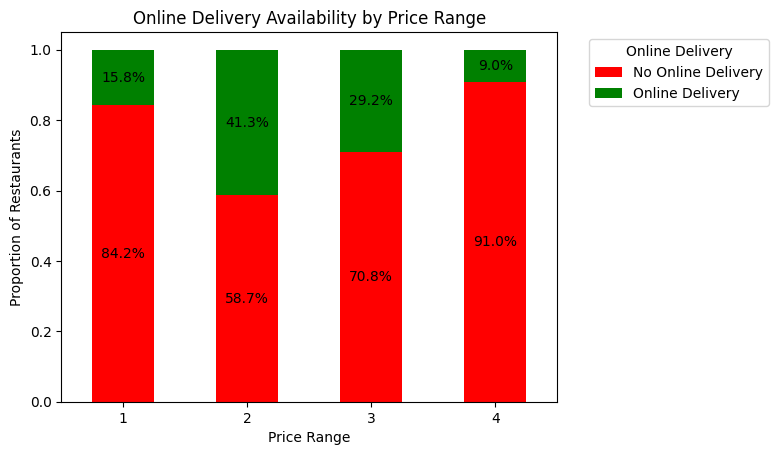

In [31]:
deli = rest_df.groupby('Price range')['Has Online delivery'].value_counts(normalize = True).unstack()
ax = deli.plot(kind = 'bar', stacked=True, color = ['red','green'])
plt.legend(['No Online Delivery', 'Online Delivery'], title='Online Delivery', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation = 0)
plt.ylabel('Proportion of Restaurants')
plt.xlabel('Price Range')
plt.title('Online Delivery Availability by Price Range')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{round(height*100, 1)}%' for height in container.datavalues],label_type='center', fontsize=10, color='black')

plt.show()

In [32]:
for i in sorted(rest_df['Price range'].unique()):
     cou = rest_df[rest_df['Price range'] == i].shape[0]
     print(f"Total numner of restaurants in price range of {i}: {cou}")

Total numner of restaurants in price range of 1: 4444
Total numner of restaurants in price range of 2: 3113
Total numner of restaurants in price range of 3: 1408
Total numner of restaurants in price range of 4: 586


In [33]:
rest_df[(rest_df['Price range'] == 2) & (rest_df['Has Online delivery'] == 'Yes')]['City'].unique()

array(['Abu Dhabi', 'Dubai', 'Ahmedabad', 'Bangalore', 'Chandigarh',
       'Chennai', 'Coimbatore', 'Faridabad', 'Ghaziabad', 'Gurgaon',
       'Hyderabad', 'Jaipur', 'Kochi', 'Kolkata', 'Mohali', 'Mumbai',
       'Nagpur', 'New Delhi', 'Noida', 'Pune', 'Secunderabad'],
      dtype=object)

In [34]:
rest_df[(rest_df['Price range'] == 4) & (rest_df['Has Online delivery'] == 'Yes')]['City'].unique()

array(['Abu Dhabi', 'Sharjah', 'Bangalore', 'Gurgaon', 'Hyderabad',
       'Jaipur', 'New Delhi', 'Noida', 'Pune'], dtype=object)

most common price range

In [35]:
price_range = rest_df['Price range'].mode()[0]
most_common = rest_df['Price range'].value_counts()[price_range]

print(f"The most common price range is {price_range}, with {most_common} resturants.")

The most common price range is 1, with 4444 resturants.


In [36]:
def cal_avg(df,price,rating):
    for i in sorted(df[price].unique()):
        avg = df[df[price] == i][rating].mean()
        print(f"The average rating for price range {i}: {round(avg,1)}")


cal_avg(rest_df,'Price range','Aggregate rating')

The average rating for price range 1: 2.0
The average rating for price range 2: 2.9
The average rating for price range 3: 3.7
The average rating for price range 4: 3.8


### Machine Learning

In [37]:
ml_df = rest_df.copy()

In [38]:
ml_df = ml_df.explode('Cuisines')

In [39]:
ml_df['Cuisines'] = ml_df['Cuisines'].str.replace(" ",'')

In [40]:
cat_encode = ['City','Locality','Currency','Country Code','Cuisines']
numerical_features = ['Longitude','Latitude','Price range','Average Cost for two','Votes']
one_hot_cat = ['Rating color','Rating text']
category_features_label = ['Has Table booking','Has Online delivery','Is delivering now','Switch to order menu']

In [41]:
for col in cat_encode:
    freq_encoding = ml_df[col].value_counts(normalize=True) 
    ml_df[f'{col}_encoded'] = ml_df[col].map(freq_encoding)

In [42]:
l_encoder = LabelEncoder()
l_encoder.classes_ = ["No","Yes"]
for col in category_features_label:
    ml_df[col] = l_encoder.fit_transform(ml_df[col])

In [43]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_cats = encoder.fit_transform(ml_df[one_hot_cat])
encoded = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(one_hot_cat))

In [44]:
ml_df = ml_df.drop(columns = ['Restaurant ID','Restaurant Name','City','Locality','Currency','Country Code','Cuisines','Address',
                              'Rating color','Rating text']).reset_index()

In [45]:
x = pd.concat([ml_df,encoded],axis = 1)
x = x.drop(columns = ['index','Aggregate rating'])
y = ml_df['Aggregate rating'] # Target variable

In [46]:
scaler = StandardScaler()
scaled = scaler.fit_transform(x)

In [47]:
x_train,x_test,y_train,y_test = train_test_split(scaled,y, test_size=0.3, random_state= 32)

linear model

In [48]:
model_li = LinearRegression()
model_li.fit(x_train,y_train)

LinearRegression()

In [49]:
yli_pred = model_li.predict(x_test)

In [50]:
mse_li = mean_squared_error(y_test,yli_pred)
r2_li = r2_score(y_test,yli_pred)

Random forest

In [51]:
model_rf = RandomForestRegressor(n_estimators=100,max_depth=10,random_state=32)
model_rf.fit(x_train,y_train)

RandomForestRegressor(max_depth=10, random_state=32)

In [52]:
yrf_pred = model_rf.predict(x_test)

In [53]:
mse_rf = mean_squared_error(y_test,yrf_pred)
r2_rf = r2_score(y_test,yrf_pred)

Decision tree

In [54]:
model_dt = DecisionTreeRegressor(max_depth=15)
model_dt.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=15)

In [55]:
ydt_pred = model_dt.predict(x_test)

In [56]:
mse_dt = mean_squared_error(y_test,ydt_pred)
r2_dt = r2_score(y_test,ydt_pred)

Knn

In [57]:
model_kn = KNeighborsRegressor(n_neighbors=5)
model_kn.fit(x_train,y_train)

KNeighborsRegressor()

In [58]:
ykn_pred = model_kn.predict(x_test)

In [59]:
mse_kn = mean_squared_error(y_test,ykn_pred)
r2_kn = r2_score(y_test,ykn_pred)

In [60]:
model_compare = pd.DataFrame({
    "Model":['Linear Regression','Random Forest Regression','Decision Tree Regression','KNN'],
    "MSE":[mse_li,mse_rf,mse_dt,mse_kn],
    "R2":[r2_li,r2_rf,r2_dt,r2_kn]
})


model_compare

,Model,MSE,R2
0,Linear Regression,0.033949,0.982852
1,Random Forest Regression,0.026756,0.986485
2,Decision Tree Regression,0.027100,0.986311
3,KNN,0.035026,0.982308


In [61]:
type(rest_df['Cuisines'].loc[0])

list

In [62]:
rest_df['Cuisines']

0              [French,  Japanese,  Desserts]
1                                  [Japanese]
2       [Seafood,  Asian,  Filipino,  Indian]
3                          [Japanese,  Sushi]
4                         [Japanese,  Korean]
                        ...                  
9546                                [Turkish]
9547      [World Cuisine,  Patisserie,  Cafe]
9548                [Italian,  World Cuisine]
9549                        [Restaurant Cafe]
9550                                   [Cafe]
Name: Cuisines, Length: 9551, dtype: object

In [63]:
rest_df['Cuisine_Type'] = rest_df['Cuisines'].apply(lambda x: 'Single' if len(x) == 1 else 'Mixed') # create a new column with values of 'Single' and 'Mixed'

In [64]:
single = rest_df[rest_df['Cuisine_Type'] == 'Single']['Aggregate rating']
mixed = rest_df[rest_df['Cuisine_Type'] == 'Mixed']['Aggregate rating']

In [65]:
t_stat,p_value = ttest_ind(single,mixed)
print(f"T-statistic: {round(t_stat,2)}, P-value: {round(p_value,2)}")

T-statistic: -21.09, P-value: 0.0


In [66]:
# To test practical significance
def cohen_d(group1,group2):
    diff = np.mean(group1) - np.mean(group2)
    l1,l2 = len(group1), len(group2)
    var1,var2 = np.var(group1), np.var(group2)
    com_var = ((l1-1)*var1 + (l2-1)*var2)/(l1+l2+2)
    d = diff/np.sqrt(com_var)
    return d


print("Cohen's d:", cohen_d(single,mixed))

Cohen's d: -0.4508249512365249


In [103]:
cuisine_df = rest_df.copy()

In [105]:
cuisine_df['Cuisines'] = cuisine_df['Cuisines'].astype('str').str.strip()

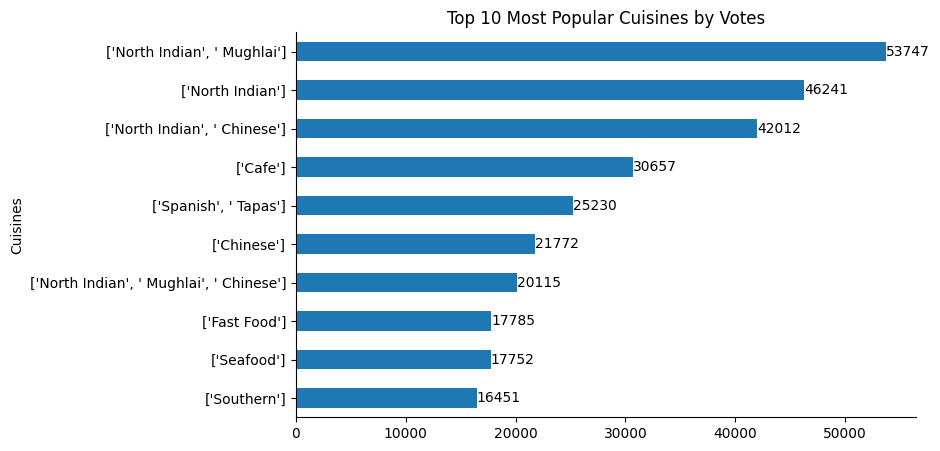

In [108]:
plt.figure(figsize=(8,5))
cusi =cuisine_df.groupby('Cuisines')['Votes'].sum().sort_values(ascending=False)[:10].plot(kind = 'barh')
cusi.bar_label(cusi.containers[0])
plt.title('Top 10 Most Popular Cuisines by Votes')
plt.gca().invert_yaxis()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

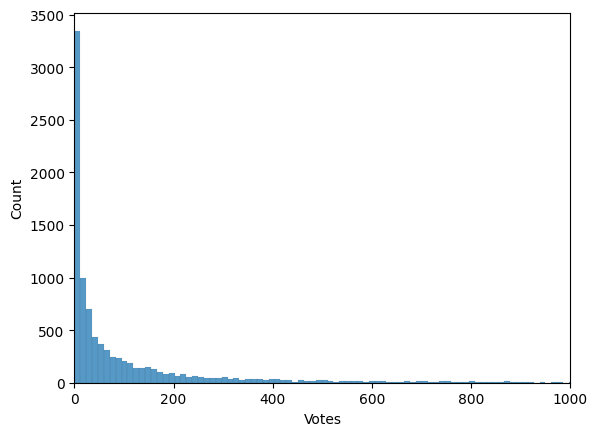

In [109]:
sns.histplot(cuisine_df['Votes'])
plt.xlim(0,1000)
plt.show()

In [110]:
med = cuisine_df['Votes'].median() # To caluculate median
med_df = cuisine_df[cuisine_df['Votes'] > med] # Filter the Restaurants with votes more than median
med_df.groupby('Cuisines')['Aggregate rating'].mean().sort_values(ascending = False)[0:10]

Cuisines
['World Cuisine']                                4.9
['American', ' Burger', ' Grill']                4.9
['Sushi', ' Japanese']                           4.9
['Sunda', ' Indonesian']                         4.9
['American', ' Coffee and Tea']                  4.9
['American', ' Caribbean', ' Seafood']           4.9
['North Indian', ' South Indian', ' Mughlai']    4.9
['Mughlai', ' Lucknowi']                         4.9
['Italian', ' Bakery', ' Continental']           4.9
['Brazilian', ' Bar Food']                       4.9
Name: Aggregate rating, dtype: float64

In [112]:
american = cuisine_df[cuisine_df['Cuisines'].str.contains('American', case = False)]['Aggregate rating']
non_american = cuisine_df[~cuisine_df['Cuisines'].str.contains('American', case = False)]['Aggregate rating']

In [116]:
t_stat,p_value = ttest_ind(american,non_american)
print(f"T-statistic: {round(t_stat,2)}, P-value: {round(p_value,2)}")
print("Cohen's d:", cohen_d(american,non_american))

T-statistic: 13.91, P-value: 0.0
Cohen's d: 0.700962426292494


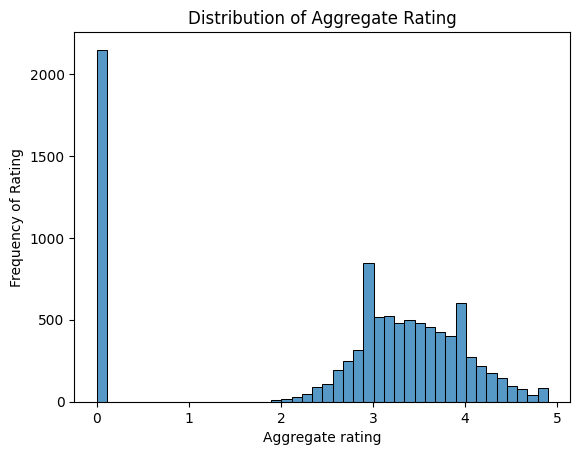

In [117]:
sns.histplot(rest_df['Aggregate rating'])
plt.title('Distribution of Aggregate Rating')
plt.ylabel('Frequency of Rating')
plt.show()

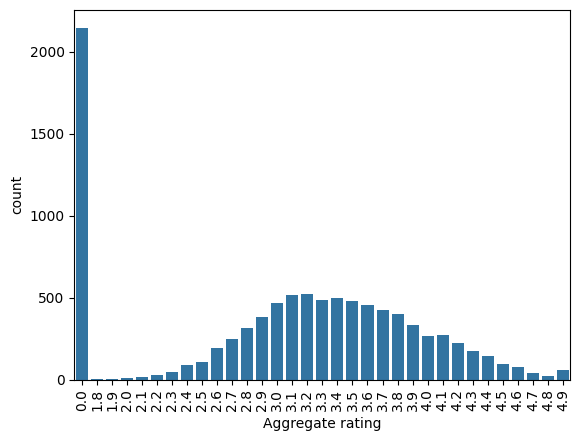

In [118]:
sns.countplot(x = 'Aggregate rating', data = cuisine_df)
plt.xticks(rotation = 90)
plt.show()

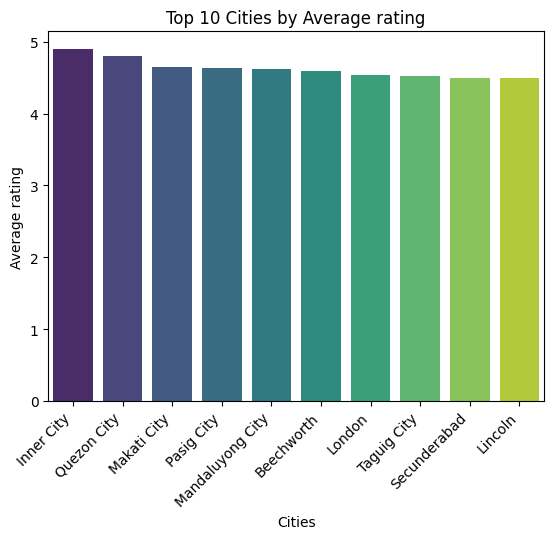

In [119]:
city_avg = cuisine_df.groupby('City')['Aggregate rating'].mean().reset_index()
city_avg.columns = ['city','average_rating']
city_avg = city_avg.sort_values(by = 'average_rating', ascending= False).head(10)

sns.barplot(x = city_avg['city'],y = city_avg['average_rating'],palette = 'viridis', hue = city_avg['city'])
plt.title('Top 10 Cities by Average rating')
plt.ylabel('Average rating')
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Cities')
plt.show()